In [1]:
%pylab inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [11]:
# Params and paths

targets = [ 0, 5, 15, 20, 30, 40, 60, 80, 100, 150, 200, 250, 300, 350, 400, 450, 500, 700, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]
beta_values = [0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 1]

sample_size = 100

In [12]:
def get_power(targets, beta_values, fname, sample_size, label_name):
    power = []
    all_powers = []
    for beta in beta_values:
        for tar in targets:   
            value = str(beta).replace(".","")
            path = f'/gymreklab-tscc/cynthiawu/Test_nullsnps/simulate_eqtls_only/FastMultivariate/Single_eqtl/SampleSize{sample_size}/SingleParameter/numTarget_{tar}/Beta_{value}/{fname}'
            cur_file = pd.read_csv(path, sep='\t')
            power.append(float(cur_file['power']))
        all_powers.append(power)
        power = []
    power_df = pd.DataFrame(all_powers, columns=targets, index=beta_values)
    return power_df

power_cpma_df = get_power(targets, beta_values, 'power_cpmax_1.0.txt', sample_size, 'CPMA_x 1.0 beta_value')
#power_pairwise_df = get_power(targets, beta_values, 'power.txt', sample_size, 'Pairwise') #?
power_mixture_df = get_power(targets, beta_values, 'power_mixtureModel.txt', sample_size, 'mixtureModel beta_value')

In [37]:
np.matrix(power_cpma_df)[0,0]

0.030000000000000027

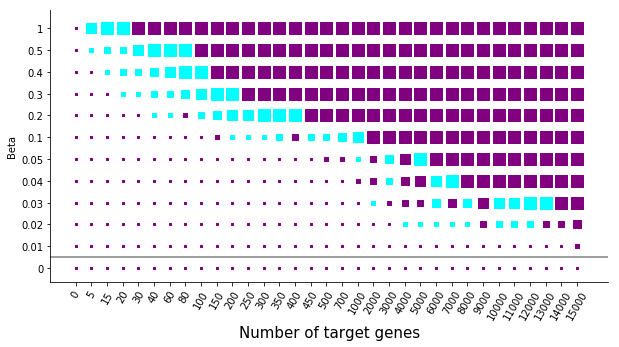

In [73]:
# Set up heatmap plotting

def power_plot(power_dfs_dict, targets, beta_values):

    # First plot power
    size_scale = 1
    fig = plt.figure()
    fig.set_size_inches((10, 5))
    
    ax1 = fig.add_subplot(111)
    size = 150
    for xval in range(len(targets)):
        for yval in range(len(beta_values)):
            color = "gray"
            best_power = 0
            for method in power_dfs_dict.keys():
                power = power_dfs_dict[method]["power"][yval, xval]
                if power > best_power:
                    best_power = power
                    color = power_dfs_dict[method]["color"]
            ax1.scatter([xval], [yval], marker='s', 
                      s=size*best_power, c=color)
    ax1.set_xticks(range(len(targets)))
    ax1.set_xticklabels(targets, rotation=60)
    ax1.set_yticks(range(len(beta_values)))
    ax1.set_yticklabels(beta_values)
    ax1.set_xlabel("Number of target genes", size=15)
    ax1.set_ylabel("Beta")
    
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    ax1.yaxis.set_ticks_position('left')
    ax1.xaxis.set_ticks_position('bottom')

    # Draw a line marking off beta=0, these can be interpreted as FPR
    ax1.axhline(y=0.5, color="gray")
    
power_dfs_dict = {
    "CPMA": {"power": np.matrix(power_cpma_df), "color": "purple"},
    "Mixture": {"power": np.matrix(power_mixture_df), "color": "cyan"}
}

power_plot(power_dfs_dict, targets, beta_values)